In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import scipy.stats as st 
import seaborn as sns
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots
sns.set_style("ticks")


In [3]:
df=pd.read_csv('data/final_model_vl_summary.csv')
df.columns

tX=pd.DataFrame()
tX['tX']=df['initT_mode']
tX['pub_id']=df['pub_id']

pkpd = pd.read_csv('data/predicted-pk-infection-day.csv')

tX = pd.merge(tX,pkpd,on='pub_id')
tX['tdet']=tX['fp_day']-tX['tX']


In [5]:
#get concentration at tdet and tPF

simC = pd.read_csv('data/sim-pk-withVLPD.csv')

cl=[]
for ip in range(len(tX)):
    dd1 = np.abs(simC['days_enrollment']-tX['tdet'].iloc[ip])
    dd2 = np.abs(simC['days_enrollment']-tX['tpf_day'].iloc[ip])

    ind1=np.where(dd1==np.min(dd1))[0][0]
    ind2=np.where(dd2==np.min(dd2))[0][0]
    
    cdet = simC['centr_conc'].iloc[ind1]
    cPF = simC['centr_conc'].iloc[ind2]
    
    tdf=tX.iloc[ip]
    
    tdet = tX['fp_day'].iloc[ip]-tX['tdet'].iloc[ip]
    tPF = tX['fp_day'].iloc[ip]-tX['tpf_day'].iloc[ip]
    
    cl.append([tdf['pub_id'],tdf['rx_lab'],tdf['gmt80mf'],tdet,tPF,cdet,cPF,])
    

In [6]:
outdf = pd.DataFrame(cl,columns=['pid','group','IC80','t_estDet','t_estPF','C_estDet','C_estPF'])

In [7]:
#czl2=['navy','tab:red','tab:blue','coral']

czl=[]
for i in range(len(outdf)):
    if outdf['IC80'].iloc[i]>1:
        czl.append('coral')
    else:
        czl.append('tab:blue')
        
outdf['color']=czl

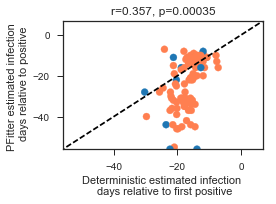

In [8]:
plt.figure(figsize=(4,3))
plt.scatter(-outdf['t_estDet'],-outdf['t_estPF'],c=outdf['color'])
#sns.regplot(-outdf['t_estDet'],-outdf['t_estPF'])
r,p = st.pearsonr(-outdf['t_estDet'],-outdf['t_estPF'])
plt.xlim([-56,7])
plt.ylim([-56,7])
plt.plot([-100,7],[-100,7],color='k',ls='--')
plt.xlabel('Deterministic estimated infection \n days relative to first positive')
plt.ylabel('PFitter estimated infection \n days relative to positive')
plt.title('r='+str(np.round(r,3))+', p='+str(np.round(p,5)))
plt.tight_layout()
plt.savefig('figures/inftimeest_methodcomparison.pdf',dpi=600)

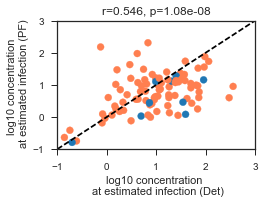

In [9]:
outdf = outdf[outdf['C_estPF']>0] #deal with 1 bad estimate

plt.figure(figsize=(4,3))
plt.scatter(np.log10(outdf['C_estDet']),np.log10(outdf['C_estPF']),c=outdf['color'])
plt.xlim([-1,3])
plt.ylim([-1,3])
plt.plot([-1,3],[-1,3],color='k',ls='--')
#plt.loglog()
plt.xlabel('log10 concentration \n at estimated infection (Det)')
plt.ylabel('log10 concentration \n at estimated infection (PF)')

r,p = st.pearsonr(np.log10(outdf['C_estDet']),np.log10(outdf['C_estPF']))
plt.title('r='+str(np.round(r,3))+', p='+str(np.round(p,10)))
plt.tight_layout()
plt.savefig('figures/infconcest_methodcomparison.pdf',dpi=600)

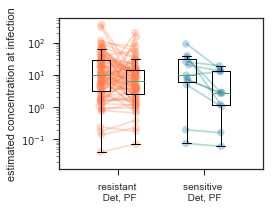

In [10]:
plt.figure(figsize=(4,3))

rdf=outdf[outdf['IC80']>1]
sdf=outdf[outdf['IC80']<1]

plt.scatter(np.random.normal(0.8,0.01,len(rdf)),rdf['C_estDet'],c=rdf['color'],alpha=0.3)
plt.scatter(np.random.normal(1.2,0.01,len(rdf)),rdf['C_estPF'],c=rdf['color'],alpha=0.3)
plt.plot([0.8*np.ones(len(rdf)),1.2*np.ones(len(rdf))],[rdf['C_estDet'],rdf['C_estPF']],c='coral',alpha=0.3)

plt.scatter(np.random.normal(1.8,0.01,len(sdf)),sdf['C_estDet'],c=sdf['color'],alpha=0.3)
plt.scatter(np.random.normal(2.2,0.01,len(sdf)),sdf['C_estPF'],c=sdf['color'],alpha=0.3)
plt.plot([1.8*np.ones(len(sdf)),2.2*np.ones(len(sdf))],[sdf['C_estDet'],sdf['C_estPF']],c='teal',alpha=0.3)

plt.boxplot([rdf['C_estDet'],rdf['C_estPF'],sdf['C_estDet'],sdf['C_estPF']],positions=[0.8,1.2,1.8,2.2])
plt.semilogy()
plt.xticks([1.,2.],['resistant \n Det, PF','sensitive \n Det, PF'])
plt.ylabel('estimated concentration at infection')
plt.tight_layout()

plt.savefig('figures/infconcest.pdf',dpi=600)

In [11]:
st.mannwhitneyu(rdf['C_estDet'],sdf['C_estDet'])

MannwhitneyuResult(statistic=448.5, pvalue=0.43990731338038985)

In [12]:
st.mannwhitneyu(rdf['C_estPF'],sdf['C_estPF'])

MannwhitneyuResult(statistic=339.5, pvalue=0.07794612885688064)

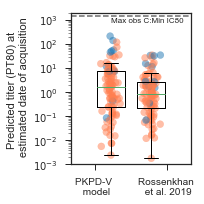

In [19]:
outdf['titer80Det'] = outdf['C_estDet']/outdf['IC80']
outdf['titer80PF'] = outdf['C_estPF']/outdf['IC80']

#get theoretical maximum titer
maxT80 = outdf['C_estDet'].max()/outdf['IC80'].min()
#maxT80 = outdf['C_estPF'].max()/outdf['IC80'].min()
#maxT80 = simC['centr_conc'].max()/outdf['IC80'].min()

plt.figure(figsize=(3,3))
plt.scatter(np.random.normal(1,0.1,len(outdf)),outdf['titer80Det'],c=outdf['color'],alpha=0.5)
plt.scatter(np.random.normal(2,0.1,len(outdf)),outdf['titer80PF'],c=outdf['color'],alpha=0.5)
plt.boxplot([outdf['titer80Det'],outdf['titer80PF']],widths=0.7)
plt.semilogy()
plt.xlim([0,3])
plt.ylim(0.001,2000)
plt.xticks([0.6,2.4,],['PKPD-V \n model','Rossenkhan \n et al. 2019'])
plt.ylabel('Predicted titer (PT80) at \n estimated date of acquisition')
plt.annotate('Max obs C:Min IC80',[1,800],fontsize=8)
plt.axhline(maxT80,ls='--',color='gray')
plt.tight_layout()
plt.savefig('figures/inftiter80.pdf',dpi=600)